In [156]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from IPython.display import clear_output
from tqdm import tqdm_notebook

In [157]:
images = pd.read_csv('./fer2013/fer2013.csv')

In [158]:
images_train = images[images['Usage']=='Training'].drop(['Usage'], axis=1)
images_test = images[images['Usage']=='PublicTest'].drop(['Usage'], axis=1)

In [159]:
def str2image(string, show=False):
    if show:
        return np.array([float(pixel) for pixel in string.split()]).reshape(48, 48)
    else:
        return np.array([float(pixel) for pixel in string.split()]).reshape(1, 48, 48)
# to use a CNN reshape to (1, 48, 48) to have at least one channel

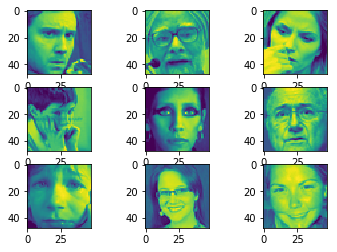

[0, 0, 2, 4, 6, 2, 4, 3, 3]


In [160]:
for i in range(0, 9):
    plt.subplot(331 + (i))
    plt.imshow(str2image(images_train['pixels'][i], True))
plt.show()
print(list(images_train['emotion'][:9]))

In [161]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

In [162]:
class FaceDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return str2image(self.data.iloc[index]['pixels']), self.data.iloc[index]['emotion']

In [163]:
train_dataloader = DataLoader(FaceDataset(images_train), batch_size=32, shuffle=True)
test_dataloader = DataLoader(FaceDataset(images_test), batch_size=32, shuffle=True)

In [164]:
class BaselineNetwork(nn.Module):
    def __init__(self):
        super(BaselineNetwork, self).__init__()
        
        self.fully_connected1 = nn.Linear(48*48, 1024)
        self.fully_connected2 = nn.Linear(1024, 7)
        
    def forward(self, batch):
        batch = batch.view(-1, 48*48) # flatted image to feed Linear layers
        batch = F.relu(self.fully_connected1(batch)) # first layer + ReLU
        batch = self.fully_connected2(batch) # second layer
        batch = F.softmax(batch, dim=1) # applying softmax
        return batch

In [165]:
model = BaselineNetwork()

In [166]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

Epoch 9
Train accuracy: 0.08934437639198219
Val accuracy: 0.09662610619469025


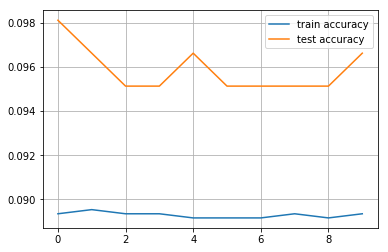

Train loss: 2.070631767567123
Val loss: 2.063492222169859


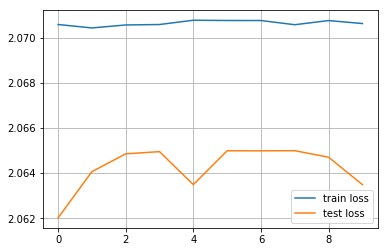

In [167]:
train_accuracy = []
train_losses = []

test_accuracy = []
test_losses = []

for epoch in range(10):
    epoch_losses = []
    epoch_accuracy = []
    
    model.train()
    for train_batch, train_labels in tqdm_notebook(train_dataloader):
        train_batch = Variable(train_batch).float()
        train_labels = Variable(train_labels).long().view(-1)
        optimizer.zero_grad()
        output = model(train_batch)
        batch_loss = loss(output, train_labels)
        batch_loss.backward()
        
        epoch_losses.append(batch_loss.data[0])
        batch_predictions = np.argmax(output.data.numpy(), axis=1)
        batch_true = train_labels.data.numpy().reshape(-1)
        epoch_accuracy.append(np.mean(batch_predictions == batch_true))
    train_accuracy.append(np.mean(epoch_accuracy))
    train_losses.append(np.mean(epoch_losses))

    
    epoch_losses = []
    epoch_accuracy = []

    model.eval()
    for test_batch, test_labels in tqdm_notebook(test_dataloader):
        test_batch = Variable(test_batch).float()
        test_labels = Variable(test_labels).long().view(-1)
        output = model(test_batch)
        batch_loss = loss(output, test_labels)
        
        epoch_losses.append(batch_loss.data[0])
        batch_predictions = np.argmax(output.data.numpy(), axis=1)
        batch_true = test_labels.data.numpy().reshape(-1)
        epoch_accuracy.append(np.mean(batch_predictions == batch_true))
    test_accuracy.append(np.mean(epoch_accuracy))
    test_losses.append(np.mean(epoch_losses))

    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_accuracy[-1])
    print("Val accuracy:", test_accuracy[-1])
    plt.plot(train_accuracy, label='train accuracy')
    plt.plot(test_accuracy, label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    print("Train loss:", train_losses[-1])
    print("Val loss:", test_losses[-1])
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend(loc='best')
    plt.grid()
    plt.show()